In [371]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

In [372]:
weather = pd.read_csv("weather_classification_data.csv")
numerical_features = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 
                     'Atmospheric Pressure', 'UV Index', 'Visibility (km)']

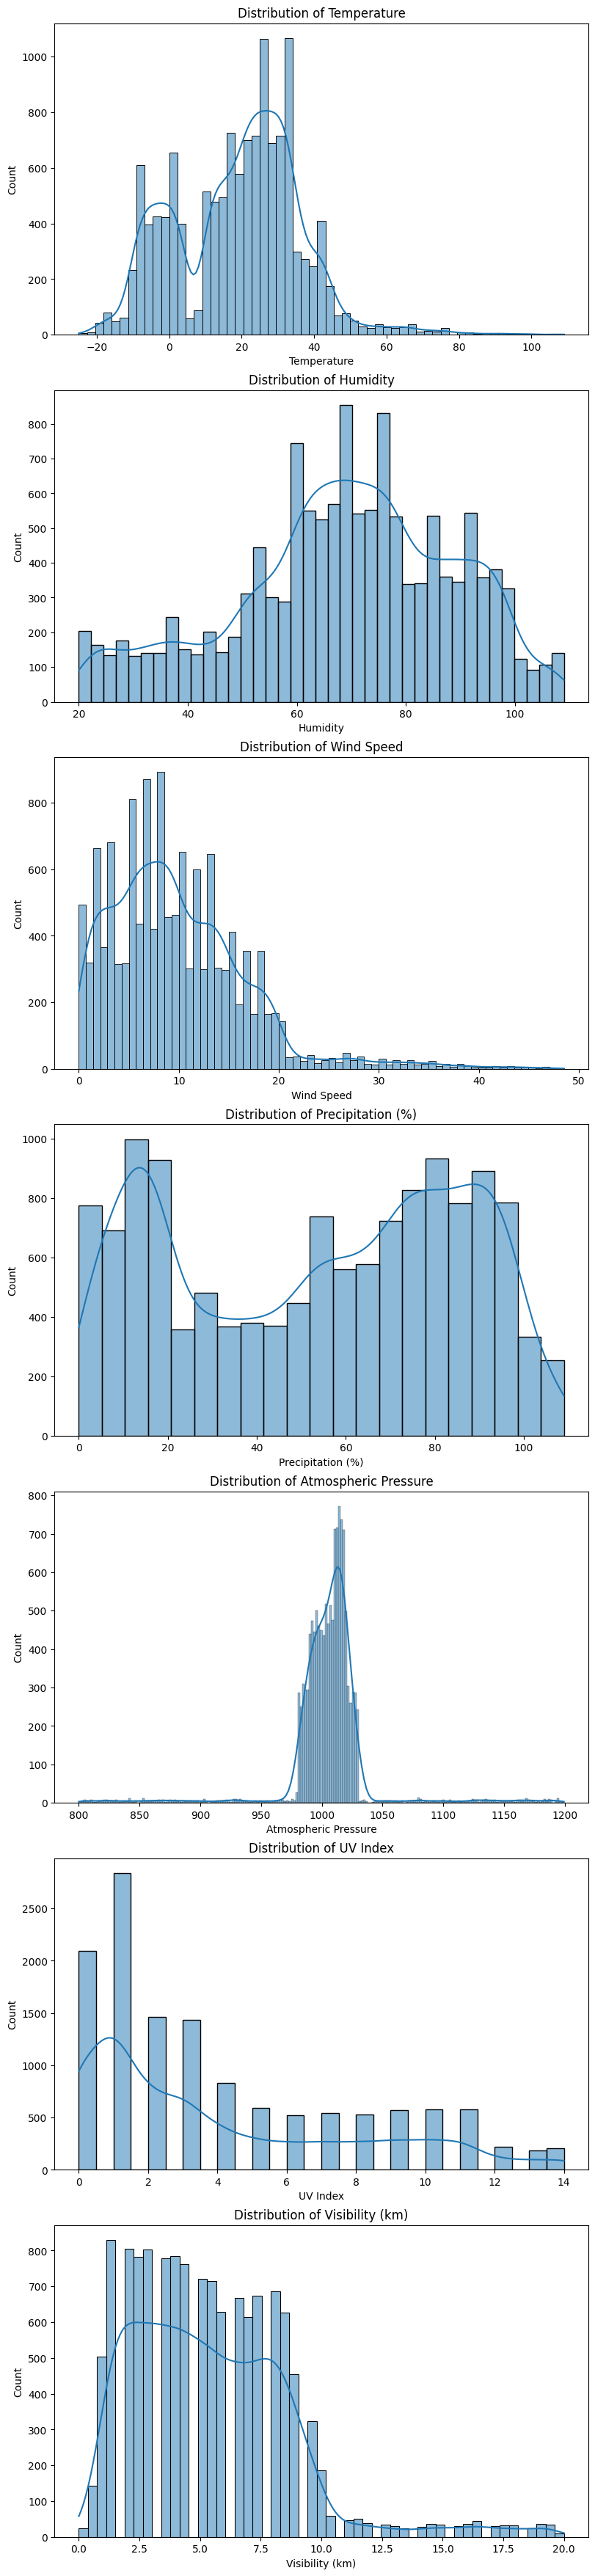

                             mean   median     mode   range     variance  \
Temperature             19.127576    21.00    32.00  134.00   302.284352   
Humidity                68.710833    70.00    76.00   89.00   407.807656   
Wind Speed               9.832197     9.00     8.00   48.50    47.730193   
Precipitation (%)       53.644394    58.00    19.00  109.00  1020.581467   
Atmospheric Pressure  1005.827896  1007.65  1013.57  399.09  1383.809399   
UV Index                 4.005758     3.00     1.00   14.00    14.873366   
Visibility (km)          5.462917     5.00     1.50   20.00    11.367005   

                        std_dev     Q1         Q3  90th_percentile  
Temperature           17.386327    4.0    31.0000           39.000  
Humidity              20.194248   57.0    84.0000           95.000  
Wind Speed             6.908704    5.0    13.5000           18.000  
Precipitation (%)     31.946541   19.0    82.0000           94.000  
Atmospheric Pressure  37.199589  994.8  1016.7

In [373]:
# Create subplots — 1 row per variable (adjust rows/cols as you like)
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(8, 5 * len(numerical_features)), constrained_layout=True)

# If only 1 column, axes might not be iterable
if len(numerical_features) == 1:
    axes = [axes]

for ax, col in zip(axes, numerical_features):
    sns.histplot(weather[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.savefig('all_histograms.png', dpi=300)
plt.show()

# Calculate descriptive features and put them in a df
summary = {}
for col in numerical_features:
    summary[col] = {
        'mean': weather[col].mean(),
        'median': weather[col].median(),
        'mode': weather[col].mode().iloc[0] if not weather[col].mode().empty else np.nan,
        'range': weather[col].max() - weather[col].min(),
        'variance': weather[col].var(),
        'std_dev': weather[col].std(),
        'Q1': weather[col].quantile(0.25),
        'Q3': weather[col].quantile(0.75),
        '90th_percentile': weather[col].quantile(0.9)
    }

summary_df = pd.DataFrame(summary).T
print(summary_df)

In [374]:
"""
Check if data follows normal distribution using the Empirical Rule (68-95-99.7 rule):
"""
normal_distribution_results = []

for feature in numerical_features:
    data = weather[feature].dropna()
    mean = data.mean()
    std = data.std()
    
    # Calculate percentages within each standard deviation range
    within_1_std = ((data >= mean - std) & (data <= mean + std)).sum()
    within_2_std = ((data >= mean - 2*std) & (data <= mean + 2*std)).sum()
    within_3_std = ((data >= mean - 3*std) & (data <= mean + 3*std)).sum()
    
    pct_1_std = (within_1_std / len(data)) * 100
    pct_2_std = (within_2_std / len(data)) * 100
    pct_3_std = (within_3_std / len(data)) * 100
    
    # Check if follows empirical rule (with some tolerance)
    follows_68 = abs(pct_1_std - 68) <= 5
    follows_95 = abs(pct_2_std - 95) <= 5
    follows_99_7 = abs(pct_3_std - 99.7) <= 5
    
    is_normal = follows_68 and follows_95 and follows_99_7
    
    normal_distribution_results.append({
        'Feature': feature,
        'Normal?': is_normal
    })

for result in normal_distribution_results:
    status = "Normal" if result['Normal?'] else "Not Normal"
    print(f"{result['Feature']}: {status}")

Temperature: Normal
Humidity: Normal
Wind Speed: Normal
Precipitation (%): Not Normal
Atmospheric Pressure: Not Normal
UV Index: Not Normal
Visibility (km): Normal



Precipitation Skewness: -0.152
(Positive = Right-skewed, Negative = Left-skewed, 0 = Symmetric)

Visualization saved as 'precipitation_histogram.png'


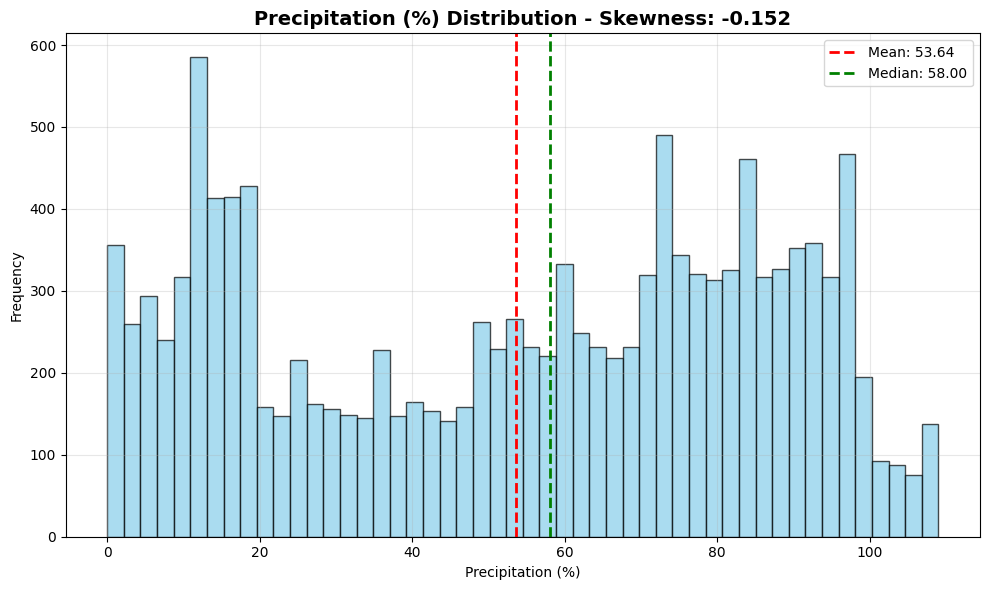

In [375]:
# Visualize precipitation skewness with histogram
precipitation_data = weather['Precipitation (%)']
skewness = stats.skew(precipitation_data)

print(f"\nPrecipitation Skewness: {skewness:.3f}")
print("(Positive = Right-skewed, Negative = Left-skewed, 0 = Symmetric)")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(precipitation_data, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(precipitation_data.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {precipitation_data.mean():.2f}')
plt.axvline(precipitation_data.median(), color='green', linestyle='--', linewidth=2, 
           label=f'Median: {precipitation_data.median():.2f}')
plt.xlabel('Precipitation (%)')
plt.ylabel('Frequency')
plt.title(f'Precipitation (%) Distribution - Skewness: {skewness:.3f}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('precipitation_histogram.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'precipitation_histogram.png'")
plt.show()


Visualization saved as 'ecdf_vs_theoretical_cdf.png'


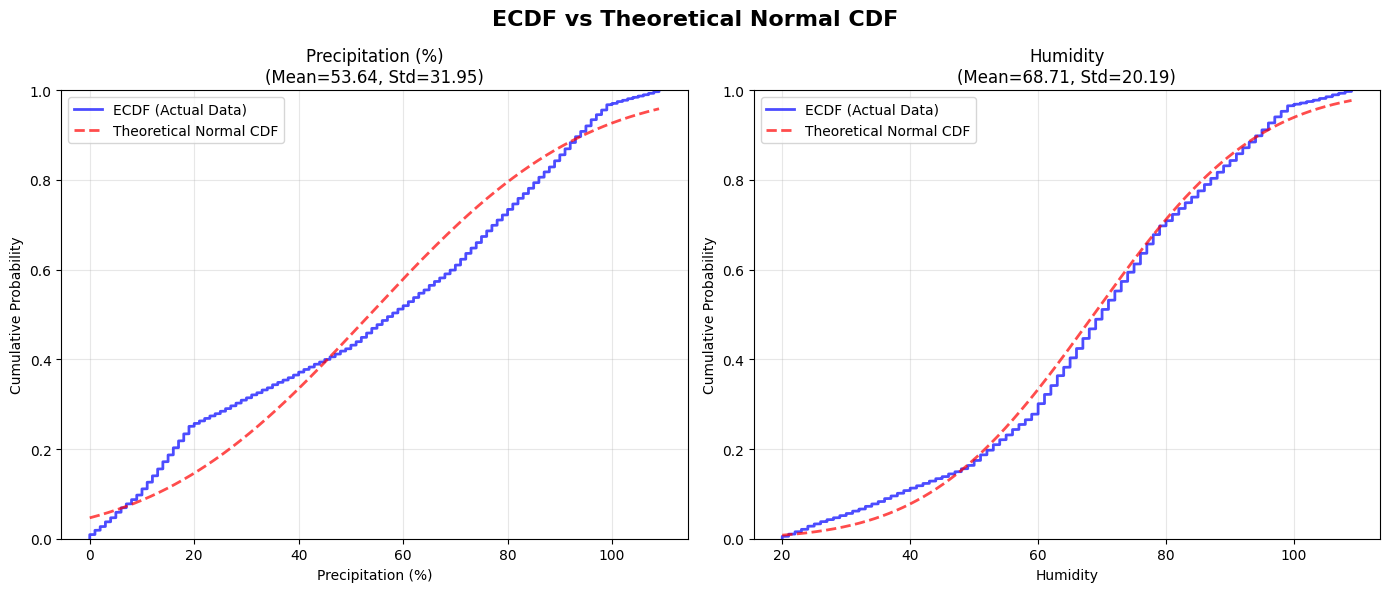

In [376]:
"""
ECDF vs Theoretical Normal CDF Comparison
ECDF (Empirical CDF) = actual cumulative distribution from your data
Theoretical Normal CDF = what it would be if data followed normal distribution
If they overlap well, the data is approximately normally distributed
"""
# Select two attributes to compare (choose features from numerical_features)
features_to_compare = ['Precipitation (%)', 'Humidity']

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('ECDF vs Theoretical Normal CDF', fontsize=16, fontweight='bold')

for idx, feature in enumerate(features_to_compare):
    data = weather[feature].dropna()
    mean = data.mean()
    std = data.std()
    
    # Calculate ECDF (Empirical Cumulative Distribution Function)
    sorted_data = np.sort(data)
    n = len(sorted_data)
    ecdf = np.arange(1, n + 1) / n  # Proportion of data points <= each value
    
    # Calculate Theoretical Normal CDF
    # Create x values for smooth theoretical curve
    x_theoretical = np.linspace(sorted_data.min(), sorted_data.max(), 1000)
    theoretical_cdf = stats.norm.cdf(x_theoretical, loc=mean, scale=std)
    
    # Plot both on the same subplot
    ax = axes[idx]
    ax.plot(sorted_data, ecdf, label='ECDF (Actual Data)', linewidth=2, color='blue', alpha=0.7)
    ax.plot(x_theoretical, theoretical_cdf, label='Theoretical Normal CDF', 
            linewidth=2, linestyle='--', color='red', alpha=0.7)
    ax.set_xlabel(feature)
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'{feature}\n(Mean={mean:.2f}, Std={std:.2f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('ecdf_vs_theoretical_cdf.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'ecdf_vs_theoretical_cdf.png'")
plt.show()

In [377]:
print("\nTotal rows = ",len(weather))


Total rows =  13200


In [378]:
"""
Preprocessing
"""
weather['location_code'] = weather['Location'].astype('category').cat.codes
weather['season_code'] = weather['Season'].astype('category').cat.codes
weather['cloud_cover_code'] = weather['Cloud Cover'].astype('category').cat.codes
weather['weather_type_code'] = weather['Weather Type'].astype('category').cat.codes

# Clean data to remove missing values - Data is already clean
# Remove outliers based on z-score
z_scores = np.abs(stats.zscore(weather.select_dtypes(include=[np.number])))
weather = weather[(z_scores < 3).all(axis=1)]
print("\nTotal rows after removing outliers",len(weather))


Total rows after removing outliers 12151


In [379]:
"""
Feature engineering and feature selection
"""

categorical_features = ['location_code', 'season_code', 'cloud_cover_code']

all_features = numerical_features + categorical_features

# Calculate mutual information scores for all features
mi_scores = mutual_info_classif(weather[all_features], weather['Weather Type'])

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': all_features,
    'mi_score': mi_scores,
    'type': ['numerical'] * len(numerical_features) + ['categorical'] * len(categorical_features)
}).sort_values('mi_score', ascending=False)

print("\nFeature Importance (Mutual Information):")
print(feature_importance)

# Select top features based on mutual information scores
# Keep features with mi_score > 0.3 (removes low-importance features)
top_features = []
for index, row in feature_importance.iterrows():
    if row['mi_score'] > 0.3:
        top_features.append(row['feature'])

# Remove low-importance columns from the main dataframe
low_importance_features = feature_importance[feature_importance['mi_score'] <= 0.3]['feature'].tolist()
weather_cleaned = weather.drop(columns=low_importance_features)
print(f"\nRemoved low-importance features: {low_importance_features}")
print(f"Dataframe shape before: {weather.shape}")
print(f"Dataframe shape after: {weather_cleaned.shape}")


# Create feature matrix with selected features
X = weather[top_features]
y = weather['Weather Type']


Feature Importance (Mutual Information):
                feature  mi_score         type
4  Atmospheric Pressure  0.694776    numerical
3     Precipitation (%)  0.636242    numerical
0           Temperature  0.621879    numerical
5              UV Index  0.523651    numerical
6       Visibility (km)  0.487691    numerical
9      cloud_cover_code  0.399326  categorical
1              Humidity  0.337548    numerical
8           season_code  0.225529  categorical
2            Wind Speed  0.165659    numerical
7         location_code  0.072953  categorical

Removed low-importance features: ['season_code', 'Wind Speed', 'location_code']
Dataframe shape before: (12151, 15)
Dataframe shape after: (12151, 12)


In [380]:
# Split data into train/test sets before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [381]:
"""
This is a preprocessing tool
Formula = (value - mean) / standard_deviation
Scale numerical features only (not categorical codes)
Allows for algorithms like KNN to not be skewed towards larger numbers
"""
scaler = StandardScaler()

# Gather only the best numerical features
numerical_selected = [f for f in top_features if f in numerical_features]

# Copy data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

"""
Apply scaling parameters to both train and test data for all numeric features
We grab the mean and standard deviation for both the training and test sets
We then apply the scaling formula to get scaled values
"""
if numerical_selected:
    X_train_scaled[numerical_selected] = scaler.fit_transform(X_train[numerical_selected])
    X_test_scaled[numerical_selected] = scaler.transform(X_test[numerical_selected])

print(f"\nFeature scaling applied to: {numerical_selected}")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# Show scaling effect (before vs after)
print(f"\nTraining data before scaling:")
print(X_train[numerical_selected])
print(f"\nTraining data after scaling:")
print(X_train_scaled[numerical_selected])


Feature scaling applied to: ['Atmospheric Pressure', 'Precipitation (%)', 'Temperature', 'UV Index', 'Visibility (km)', 'Humidity']
Training set shape: (9720, 7)
Test set shape: (2431, 7)

Training data before scaling:
       Atmospheric Pressure  Precipitation (%)  Temperature  UV Index  \
7285                1019.18               14.0         32.0         5   
7201                 987.50               61.0        -10.0         1   
7493                 998.76               96.0         -8.0         0   
2856                1008.95               38.0         19.0         3   
9272                 990.49               72.0         29.0         0   
...                     ...                ...          ...       ...   
11489               1010.03               14.0         14.0         3   
12574                996.07               68.0         -3.0         1   
11219               1019.34               94.0         23.0         8   
6925                1006.07               50.0    

In [382]:
def plot_roc_curve_multiclass(model, X_train, X_test, y_train, y_test, model_name):
    #Plot ROC curve for multiclass classification and check for overfitting
    if not hasattr(model, 'predict_proba'):
        print(f"{model_name}: Model does not support probability prediction, skipping ROC curve")
        return None
    
    # Get predicted probabilities for test set
    y_pred_proba_test = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    y_train_bin = label_binarize(y_train, classes=classes)
    n_classes = y_test_bin.shape[1]
    
    # Calculate ROC AUC for both train and test
    try:
        roc_auc_test = roc_auc_score(y_test_bin, y_pred_proba_test, average='macro', multi_class='ovr')
        roc_auc_train = roc_auc_score(y_train_bin, y_pred_proba_train, average='macro', multi_class='ovr')
        
        print(f"\n{model_name} ROC AUC:")
        print(f"  Train: {roc_auc_train:.3f}")
        print(f"  Test:  {roc_auc_test:.3f}")
        print(f"  Gap:   {roc_auc_train - roc_auc_test:.3f}")
        
        # Check for overfitting
        auc_gap = roc_auc_train - roc_auc_test
        roc_auc = roc_auc_test
    except Exception as e:
        print(f"{model_name}: Could not calculate ROC AUC - {e}")
        return None
    
    # Plot ROC curve for each class (test set)
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i in range(n_classes):
        # Check if class has both positive and negative samples
        pos_samples = np.sum(y_test_bin[:, i] == 1)
        neg_samples = np.sum(y_test_bin[:, i] == 0)
        
        if pos_samples == 0 or neg_samples == 0:
            continue
            
        try:
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba_test[:, i])
            class_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba_test[:, i])
            
            # Check for edge cases
            if len(fpr) < 2 or len(tpr) < 2:
                continue
            
            plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                    label=f'Class {classes[i]} (AUC = {class_auc:.3f})')
        except Exception:
            continue
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve - Test Set\n(Macro AUC = {roc_auc:.3f}, Train AUC = {roc_auc_train:.3f})')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

Fitting 3 folds for each of 15 candidates, totalling 45 fits

KNN Best Parameters: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'euclidean'}
KNN Best CV Score: 0.948
KNN Test Accuracy: 0.945
KNN Test Precision: 0.946

KNN ROC AUC:
  Train: 0.998
  Test:  0.989
  Gap:   0.009


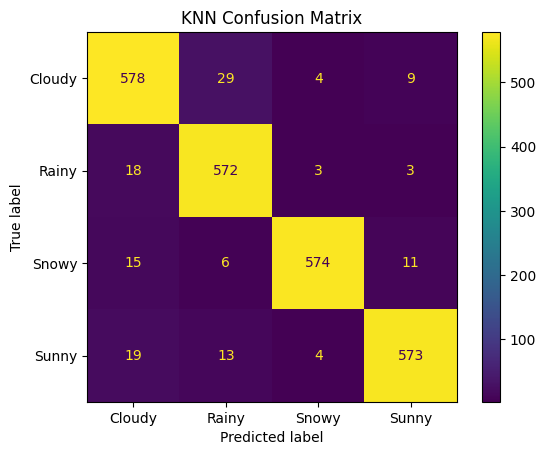

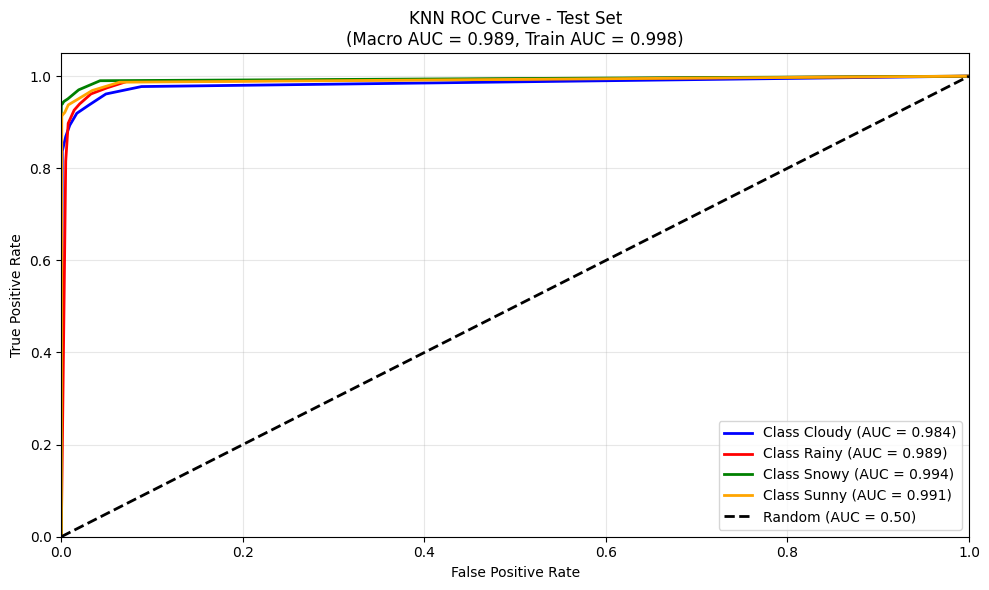

In [383]:
"""
KNN
"""
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_base = KNeighborsClassifier()
knn_search = RandomizedSearchCV(
    knn_base, knn_param_grid, n_iter=15, cv=3, 
    scoring='accuracy', n_jobs=2, random_state=42, verbose=1
)
knn_search.fit(X_train_scaled, y_train)
model = knn_search.best_estimator_
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\nKNN Best Parameters: {knn_search.best_params_}")
print(f"KNN Best CV Score: {knn_search.best_score_:.3f}")
print(f"KNN Test Accuracy: {accuracy:.3f}")
print(f"KNN Test Precision: {precision:.3f}")
cm = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('KNN Confusion Matrix')
roc_auc = plot_roc_curve_multiclass(model, X_train_scaled, X_test_scaled, y_train, y_test, "KNN")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Decision Tree Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 8, 'max_depth': 7, 'criterion': 'gini'}
Decision Tree Best CV Score: 0.951
Decision Tree Test Accuracy: 0.947
Decision Tree Test Precision: 0.947

Decision Tree ROC AUC:
  Train: 0.998
  Test:  0.991
  Gap:   0.007


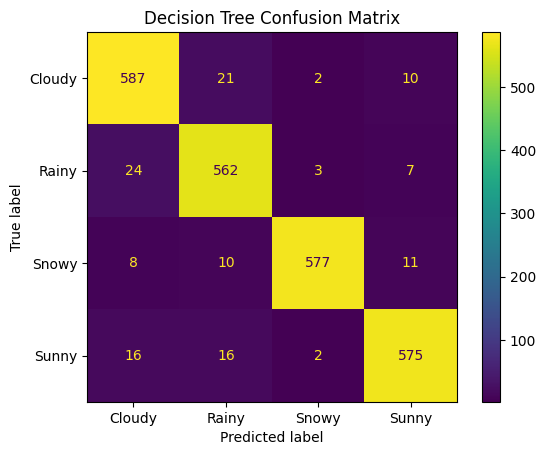

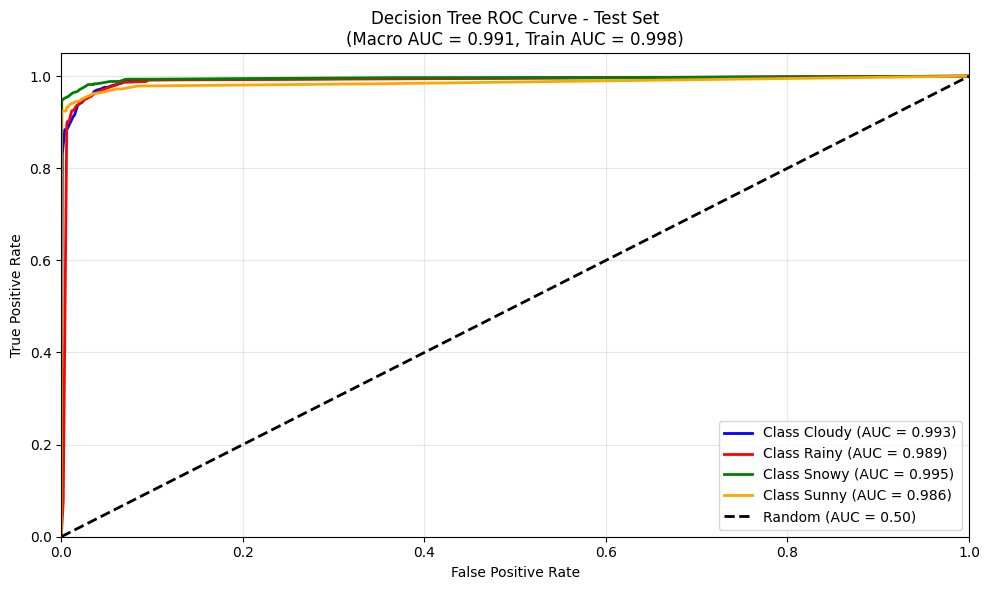

In [384]:
"""
Decision Tree
"""
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}
dt_base = DecisionTreeClassifier(random_state=42)
dt_search = RandomizedSearchCV(
    dt_base, dt_param_grid, n_iter=20, cv=3,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
dt_search.fit(X_train_scaled, y_train)
model = dt_search.best_estimator_
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\nDecision Tree Best Parameters: {dt_search.best_params_}")
print(f"Decision Tree Best CV Score: {dt_search.best_score_:.3f}")
print(f"Decision Tree Test Accuracy: {accuracy:.3f}")
print(f"Decision Tree Test Precision: {precision:.3f}")
cm = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('Decision Tree Confusion Matrix')
roc_auc = plot_roc_curve_multiclass(model, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Random Forest Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None}
Random Forest Best CV Score: 0.953
Random Forest Test Accuracy: 0.951
Random Forest Test Precision: 0.951

Random Forest ROC AUC:
  Train: 1.000
  Test:  0.997
  Gap:   0.002


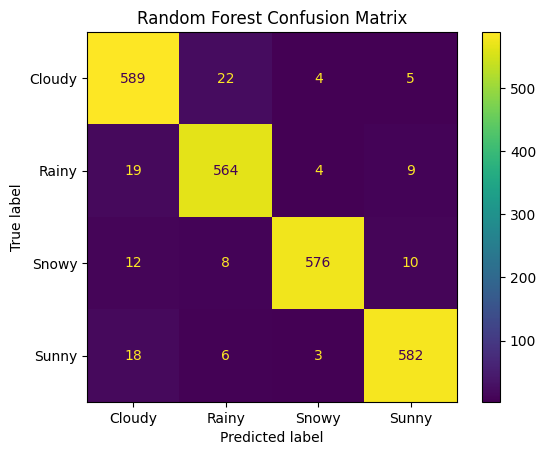

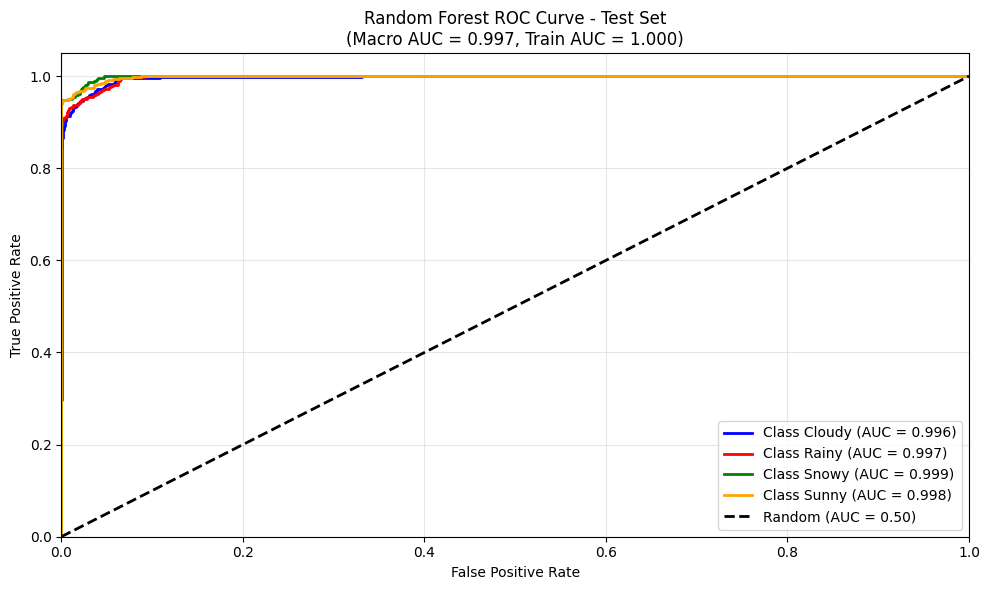

In [385]:
"""
Random Forest
"""
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf_base, rf_param_grid, n_iter=15, cv=3,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
rf_search.fit(X_train_scaled, y_train)
model = rf_search.best_estimator_
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\nRandom Forest Best Parameters: {rf_search.best_params_}")
print(f"Random Forest Best CV Score: {rf_search.best_score_:.3f}")
print(f"Random Forest Test Accuracy: {accuracy:.3f}")
print(f"Random Forest Test Precision: {precision:.3f}")
cm = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('Random Forest Confusion Matrix')
roc_auc = plot_roc_curve_multiclass(model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

SVM Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}
SVM Best CV Score: 0.950
SVM Test Accuracy: 0.943
SVM Test Precision: 0.944
SVM: Model does not support probability prediction, skipping ROC curve


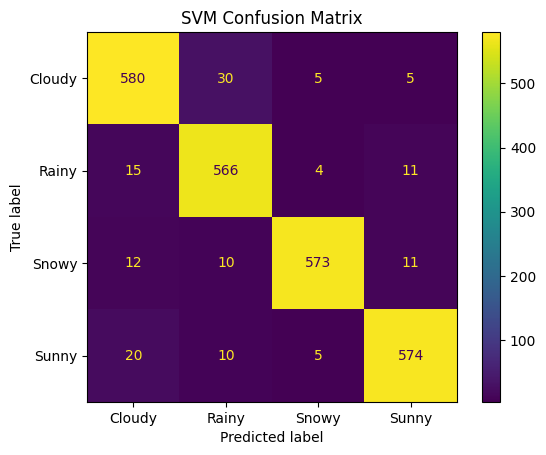

In [386]:
"""
SVM
"""
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}
svm_base = SVC(random_state=42)
svm_search = RandomizedSearchCV(
    svm_base, svm_param_grid, n_iter=15, cv=3,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
svm_search.fit(X_train_scaled, y_train)
model = svm_search.best_estimator_
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\nSVM Best Parameters: {svm_search.best_params_}")
print(f"SVM Best CV Score: {svm_search.best_score_:.3f}")
print(f"SVM Test Accuracy: {accuracy:.3f}")
print(f"SVM Test Precision: {precision:.3f}")
cm = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('SVM Confusion Matrix')
roc_auc = plot_roc_curve_multiclass(model, X_train_scaled, X_test_scaled, y_train, y_test, "SVM")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Logistic Regression Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
Logistic Regression Best CV Score: 0.916
Logistic Regression Test Accuracy: 0.912
Logistic Regression Test Precision: 0.913

Logistic Regression ROC AUC:
  Train: 0.972
  Test:  0.967
  Gap:   0.005


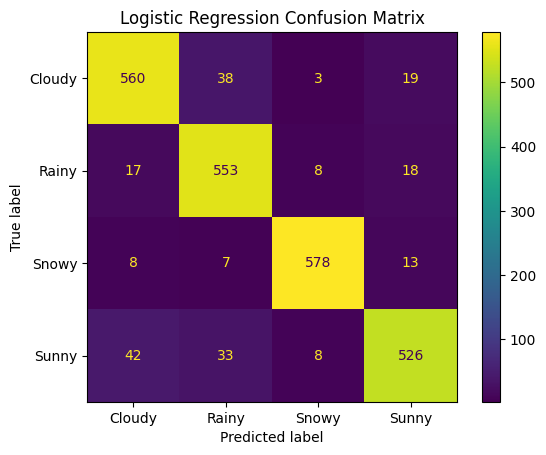

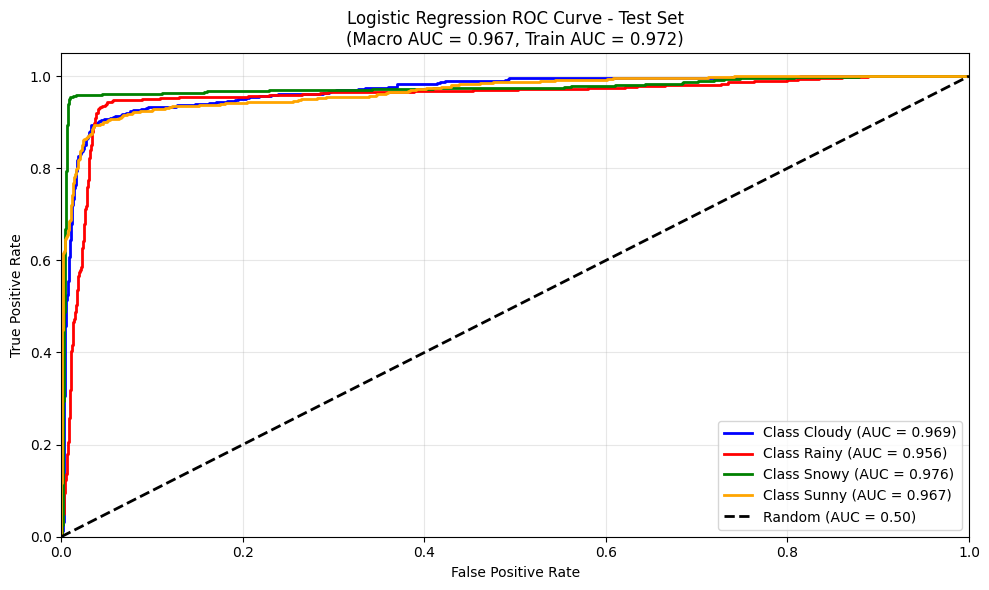

In [387]:
"""
Logistic Regression
"""
lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}
lr_base = LogisticRegression(random_state=42, max_iter=1000)
lr_search = RandomizedSearchCV(
    lr_base, lr_param_grid, n_iter=15, cv=3,
    scoring='accuracy', n_jobs=-1, random_state=42, verbose=1
)
lr_search.fit(X_train_scaled, y_train)
model = lr_search.best_estimator_
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"\nLogistic Regression Best Parameters: {lr_search.best_params_}")
print(f"Logistic Regression Best CV Score: {lr_search.best_score_:.3f}")
print(f"Logistic Regression Test Accuracy: {accuracy:.3f}")
print(f"Logistic Regression Test Precision: {precision:.3f}")
cm = ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('Logistic Regression Confusion Matrix')
roc_auc = plot_roc_curve_multiclass(model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")